<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 3: Holt-Winters exponential smoothing</h2></center>
<br>

In this tutorial we will study how to apply exponential smoothing methods to forecast seasonal data in Python. 

<a class="buttom" href=">#Data:-NSW-retail-turnover">Data: NSW retail turnover</a> <br>
<a class="buttom" href="#Time-series-decomposition">Time series decomposition</a> <br>
<a class="buttom" href="#Trend-corrected-exponential-Smoothing">Trend corrected exponential smoothing</a> <br>
<a class="buttom" href="#Hold-Exponential-Smoothing">Holt-Winters smoothing</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook relies on the following imports and settings

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## Data: NSW Retail turnover

In this tutorial we will keep working with the Australian retail turnover series. The next cells load the data and reproduces some of the steps from last week. 

In [3]:
data = pd.read_csv('datasets/nswretail.csv', index_col='Month', parse_dates=True, dayfirst=True)
data.tail()

,Turnover
Month,
2018-05-01,8438.3
2018-06-01,8354.4
2018-07-01,8304.6
2018-08-01,8474.8
2018-09-01,8387.7


In [4]:
y = data['Turnover'].copy()
y.index = y.index.to_period(freq='M')

ts = data['Turnover']

In [5]:
data.describe().round(2)

,Turnover
count,438.00
mean,4335.57
std,2164.08
min,1214.50
25%,2566.80
50%,3930.70
75%,5986.15
max,10960.70


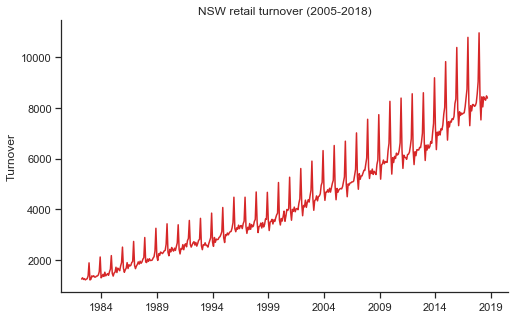

In [6]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('NSW retail turnover (2005-2018)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

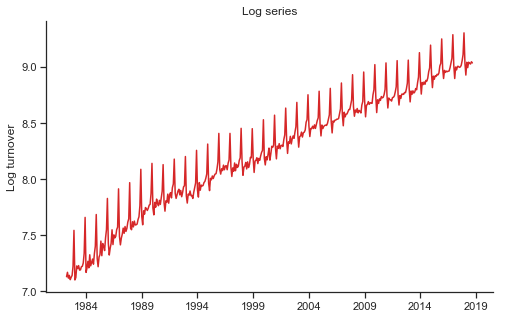

In [7]:
fig, ax= plt.subplots(figsize=(8,5))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log turnover')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Time series decomposition

We use the X-13 ARIMA-SEATS method for time series decomposition. The X-13 method is a state-of-art time series decomposition approach developed and provided by the [US Census Bureau](https://www.census.gov/srd/www/x13as/) as external software. You need to make the X-13 software available to Python by downloading it from the link and extracting the compressed folder to your computer. The <TT>statsmodels</TT> library has a function that interfaces with this software, and the easiest way to get it to work is to copy the <TT>x13as</TT> executable to the same folder as your notebook.  

The X-13 is the current version of the X-12-ARIMA method described in the [textbook](https://www.otexts.org/fpp/6/4). The only limitation is that the X-13 software makes calendar effect adjustments based on the US calendar by default, though it is possible to reconfigure it to other calendars. Refer to the [ABS](http://abs.gov.au/websitedbs/d3310114.nsf/4a256353001af3ed4b2562bb00121564/c890aa8e65957397ca256ce10018c9d8) for the seasonal adjustment standards in Australia.  

In Linux you can use `get-x13as.sh` to get it.

In [11]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

You can use the <TT>dir</TT> method to check the available output. 

In [12]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [13]:
decomposition.seasadj.tail()

Month
2018-05-01    8685.001859
2018-06-01    8678.781774
2018-07-01    8651.566337
2018-08-01    8804.640295
2018-09-01    8621.053459
Name: seasadj, dtype: float64

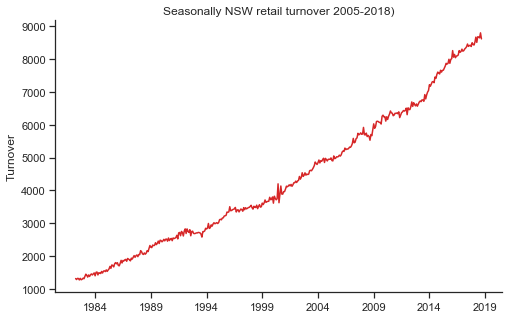

In [14]:
fig, ax= plt.subplots(figsize=(8,5))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally NSW retail turnover 2005-2018)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

The <TT>forecast</TT> module has a convenient function for plotting the components. 

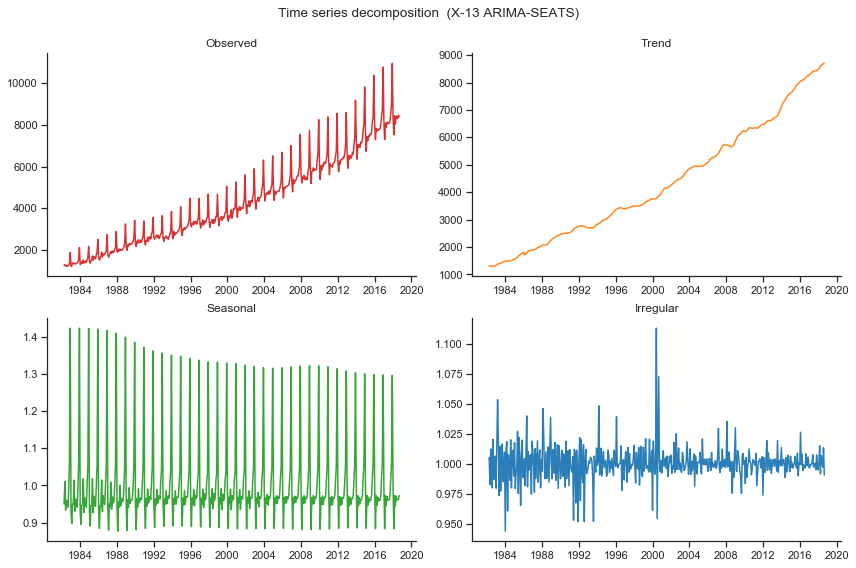

In [15]:
from forecast import plot_components_x13
plot_components_x13(decomposition)
plt.show()

The X-13-ARIMA software generates a very detailed analysis of the time series, which is stored in the <TT>results</TT> attribute. You can view it with the <TT>print(decomposition.results)</TT> command, but due to the length I recommend saving it to a text file and opening it elsewhere. You can do this as follows.  

In [16]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

In case you are not able to work with the X13 decomposition software, a more basic decomposition is available as follows.

In [17]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

## Trend corrected exponential smoothing

Before we model and forecast the original series, the next cells demonstrate the application of the trend corrected exponential smoothing method, focusing on the seasonally adjusted series for coherence. 

In [18]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

In [22]:
import forecast
holt = forecast.holt(ts)
holt.fit()
holt.summary()

 Holt (trend corrected) exponential smoothing

 Smoothing parameters: 
 alpha (level) 0.426 (0.029)
 beta (trend)  0.026 (0.013)
 
 In-sample fit:
 MSE               5119.334
 Log-likelihood   -2491.926
 AIC               4989.852
 BIC               5002.098


In [31]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
#loglik_sm = model_sm.model.loglike(model_sm.model.params) #NotImplementedError
loglik_sm = 'N/A'
aic_sm = model_sm.aic
bic_sm = model_sm.bic
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))
print(' Log-likelihood    %s' % (loglik_sm))
print(' AIC               {0:.3f}'.format(aic_sm))
print(' BIC               {0:.3f}'.format(bic_sm))

 Smoothing parameter: alpha  0.424
 In-sample fit:
 MSE               5083.849
 Log-likelihood    N/A
 AIC               3745.815
 BIC               3762.144


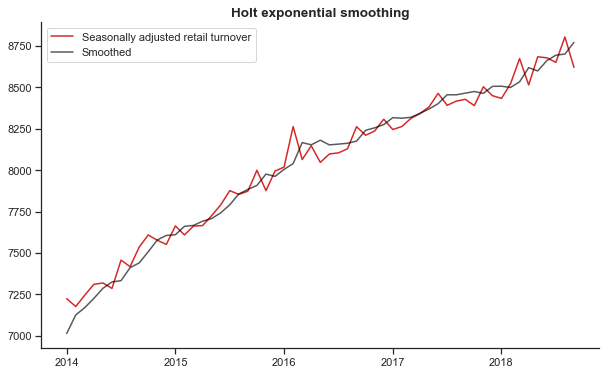

In [32]:
smoothed=pd.Series(holt.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

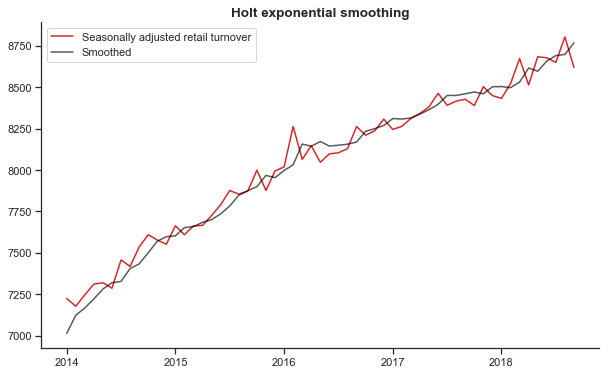

In [33]:
smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots(figsize=(10,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

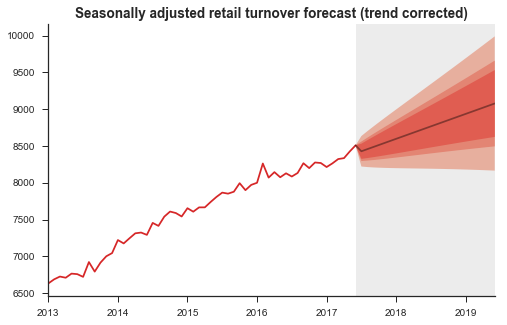

In [18]:
h=24

test=pd.period_range(start=ts.index[-1]+1, periods=h, freq='M')

pred=pd.Series(holt.forecast(h), index=test)

intv1=pd.DataFrame(holt.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(holt.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(holt.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(ts['01-2013':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Seasonally adjusted retail turnover forecast (trend corrected)', fontsize=13.5, fontweight='bold')

sns.despine()
plt.show()

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

In [19]:
ahw=forecast.holtwinters(y, additive=True, damped=False, m=12)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.575 (0.072)
 beta  (trend)    0.027 (0.017)
 delta (seasonal) 1.000 (0.173)
 
 In-sample fit:
 MSE               13865.368
 RMSE              117.751
 Log-likelihood   -853.877
 AIC               1715.754
 BIC               1727.463


In [20]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.459 (0.071)
 beta  (trend)    0.024 (0.012)
 delta (seasonal) 0.704 (0.144)
 
 In-sample fit:
 MSE               13016.536
 RMSE              114.090
 Log-likelihood   -849.518
 AIC               1707.036
 BIC               1718.745


In [21]:
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.330 (0.114)
 beta  (trend)    1.000 (0.558)
 delta (seasonal) 0.552 (0.170)
 phi (damping)    0.270 (0.198)
 
 In-sample fit:
 MSE               13608.225
 RMSE              116.654
 Log-likelihood   -852.585
 AIC               1715.170
 BIC               1729.807


In [22]:
ahw_log=forecast.holtwinters(np.log(y), additive=True, damped=False, m=12)
ahw_log.fit()
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.529 (0.074)
 beta  (trend)    0.022 (0.014)
 delta (seasonal) 0.823 (0.162)
 
 In-sample fit:
 MSE               0.000
 RMSE              0.018
 Log-likelihood    358.566
 AIC               -709.132
 BIC               -697.423


The smoothed series based on the multiplicative method tracks the original series very closely.

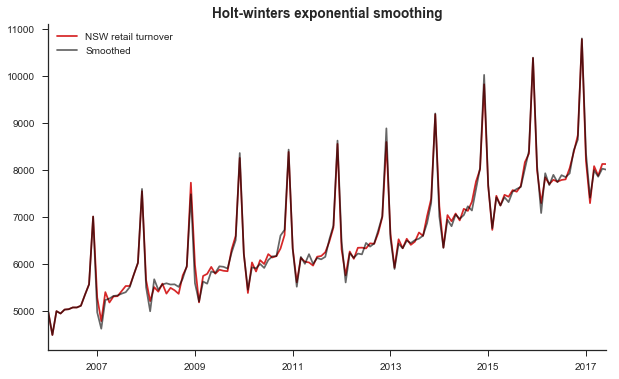

In [23]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='NSW retail turnover')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

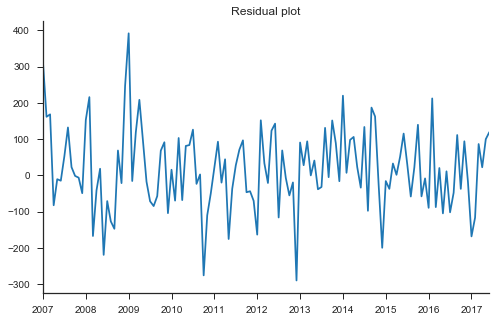

In [24]:
resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

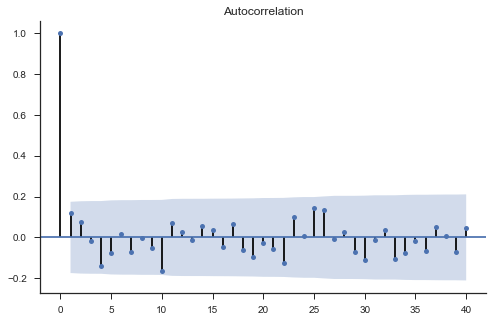

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

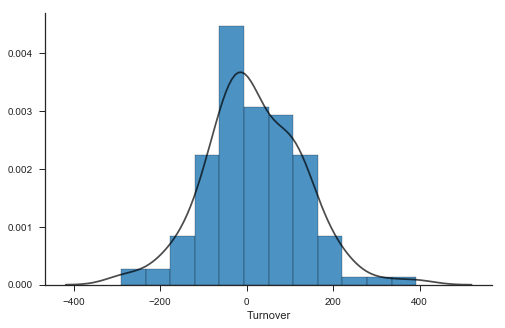

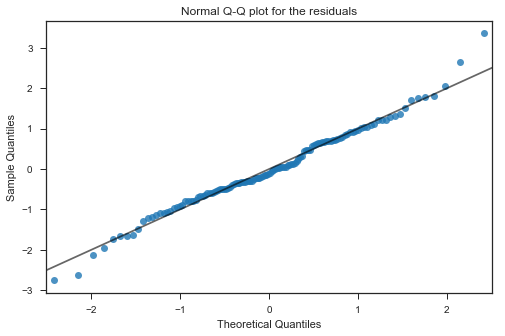

In [26]:
from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

In [27]:
print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

Residual skewness: 0.163
Residual kurtosis: 0.788


## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [28]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y['2012-01':].index
start = y.index.get_loc('2012-01') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [29]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,385.73,21.12
Additive,146.49,17.78
Multiplicative,134.39,10.07
Log additive,129.95,10.75


## Forecast

Finally, we generate a two year forecast based on the selected model. 

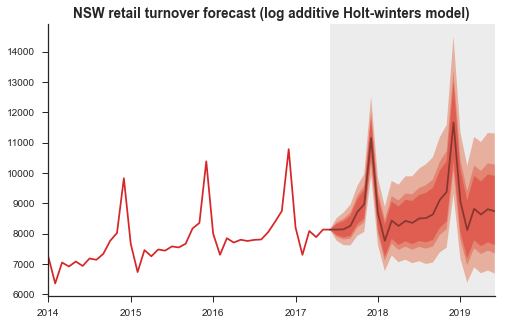

In [30]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred=pd.Series(ahw_log.forecast(h), index=test)
var = ahw_log.forecastvariance(h)
pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(ahw_log.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahw_log.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahw_log.intervalforecast(h, level=.99), index=test)
intv1=np.exp(intv1)
intv2=np.exp(intv2)
intv3=np.exp(intv3)

fig, ax = forecast.fanchart(y['01-2014':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('NSW retail turnover forecast (log additive Holt-winters model)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()